In [1]:
import os

import rasterio
import geopandas as gpd
import pandas as pd
import matplotlib

from fct_misc import get_pixel_values, ensure_dir_exists
from fct_stats import pca_procedure

In [2]:
DATA_PATH='/mnt/data-01/gsalamin/deperissement-hetre/'
NORTH_ORTHO=os.path.join(DATA_PATH, 'initial/True_ortho/North.tif')
SOUTH_ORTHO=os.path.join(DATA_PATH, 'initial/True_ortho/South.tif')
BEECHES_POLYGONS=os.path.join(DATA_PATH, 'processed/Polygones_segmentation/segmented_trees.gpkg')
BEECHES_LAYER='ConcavHull_Segmentation'

written_files=[]


# Import data

In [3]:
beeches=gpd.read_file(BEECHES_POLYGONS, layer=BEECHES_LAYER)
beeches

,id,etat_sanitaire,layer,zone,geometry
0,36,malade,segmented_trees — Malade 36,Beurnevesin,"POLYGON ((2574707.861 1260382.777, 2574708.065..."
1,189,malade,segmented_trees — Malade_189,Miecourt,"POLYGON ((2581568.402 1253341.406, 2581568.508..."
2,57,malade,segmented_trees — Malade_57,Beurnevesin,"POLYGON ((2574680.129 1260252.560, 2574680.181..."
3,70,malade,segmented_trees — Malade_70,Beurnevesin,"POLYGON ((2576768.358 1261135.809, 2576768.676..."
4,80,malade,segmented_trees — Malade_80,Beurnevesin,"POLYGON ((2577048.261 1261281.564, 2577048.537..."
5,41,mort,segmented_trees — Mort_41,Beurnevesin,"POLYGON ((2574294.379 1260311.222, 2574294.500..."
6,49,mort,segmented_trees — Mort_49,Beurnevesin,"POLYGON ((2574448.000 1260422.125, 2574448.250..."
7,77,mort,segmented_trees — Mort_77,Beurnevesin,"POLYGON ((2576568.473 1261181.721, 2576568.642..."
8,160,sain,segmented_trees — Sain_160,Miecourt,"POLYGON ((2582023.750 1253537.750, 2582025.000..."
9,239,sain,segmented_trees — Sain_239,Miecourt,"POLYGON ((2582763.273 1253739.959, 2582763.372..."


In [4]:
beeches_south=beeches[beeches['zone']=='Miecourt']
pixels_south=pd.DataFrame()
for beech in beeches_south.itertuples():
    pixels=get_pixel_values(beech.geometry, SOUTH_ORTHO, bands=range(1,5), health_status=beech.etat_sanitaire)

    pixels_south=pd.concat([pixels_south, pixels])

In [5]:
beeches_north=beeches[beeches['zone']=='Beurnevesin']
pixels_north=pd.DataFrame()
for beech in beeches_north.itertuples():
    pixels=get_pixel_values(beech.geometry, NORTH_ORTHO, bands=range(1,5), health_status=beech.etat_sanitaire)

    pixels_north=pd.concat([pixels_north, pixels])

In [6]:
pixels_beeches=pd.concat([pixels_north, pixels_south], ignore_index=True)

In [7]:
del pixels_north, pixels_south, pixels

In [8]:
pixels_beeches.rename(columns={'band1':'R', 'band2':'G', 'band3':'B', 'band4':'NIR'}, inplace=True)


In [9]:
pixels_beeches['NDVI']=(pixels_beeches['NIR'].astype('float64')-
                            pixels_beeches['R'].astype('float64'))/(pixels_beeches['NIR'].astype('float64')+
                                                                            pixels_beeches['R'].astype('float64'))

pixels_beeches.loc[pixels_beeches['health_status']=='sain', 'health_status']='1. sain'
pixels_beeches.loc[pixels_beeches['health_status']=='malade', 'health_status']='2. malade'
pixels_beeches.loc[pixels_beeches['health_status']=='mort', 'health_status']='3. mort'


In [10]:
table_path=ensure_dir_exists(os.path.join(DATA_PATH, 'final/tables'))
im_path=ensure_dir_exists(os.path.join(DATA_PATH, 'final/images'))

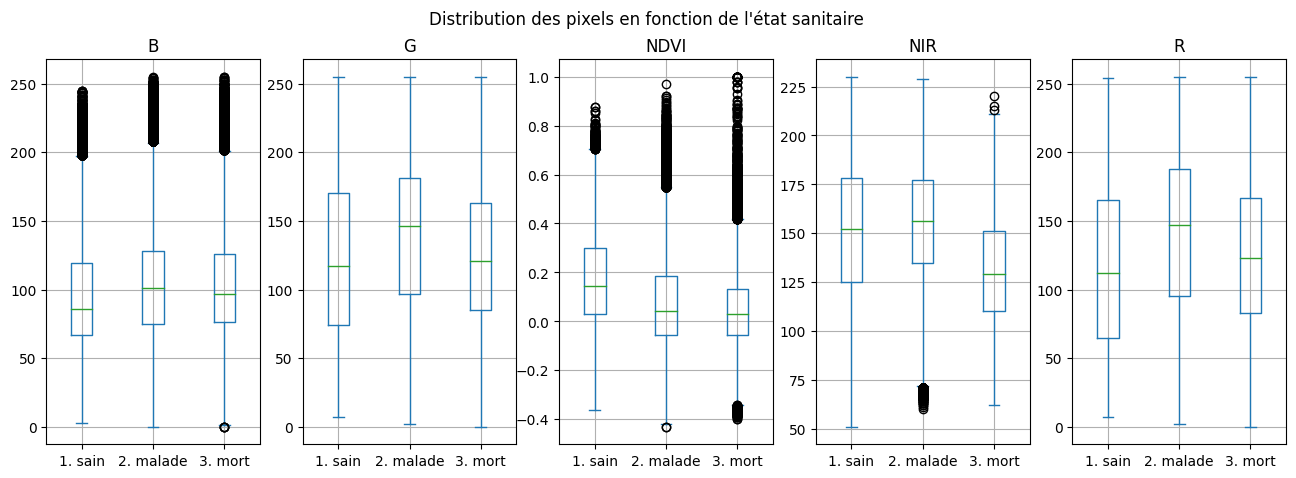

In [11]:
boxplots=pixels_beeches.plot.box(by='health_status',
                            title='Distribution des pixels en fonction de l\'état sanitaire',
                            figsize=(16,5),
                            grid=True)
fig = boxplots[0].get_figure()
filename=os.path.join(im_path, 'bxplt_distribution_status_health.jpg')
fig.savefig(filename, bbox_inches='tight')
written_files.append(filename)

The number of components to keep was 0. The number of components to keep is set to 1 and the number of components to plot is set to 2.


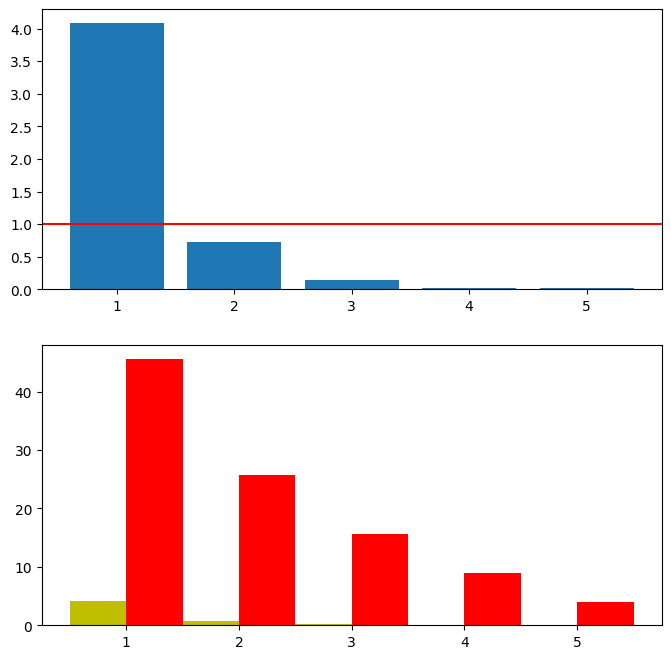

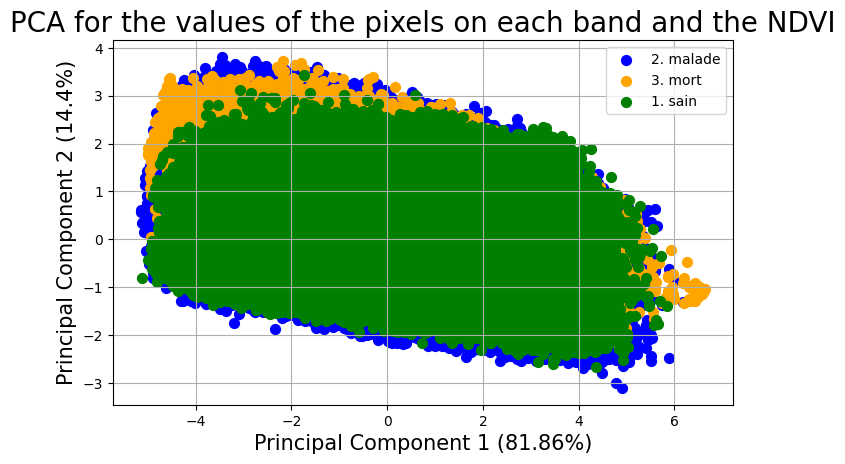

In [12]:
features = ['R', 'G', 'B', 'NIR', 'NDVI']
to_describe='health_status'

written_files_pca_pixels=pca_procedure(pixels_beeches, features, to_describe,
                        table_path, im_path, 
                        file_prefix=f'PCA_beeches_',
                        title_graph='PCA for the values of the pixels on each band and the NDVI')

written_files.extend(written_files_pca_pixels)